## Visualize the boundary condition forcing file

In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import cmocean
from matplotlib.patches import ConnectionPatch
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import MultipleLocator
import gsw

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_BB  = (imin,imin,449,674)   # Baffin Bay
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

In [3]:
# Colors
land_color = '#a9a7a2'

color_sBB = '#cc0e1d'# '#b0165f'
color_sGR = '#ffb7aa'#'#ff9966'
color_wCB = '#0873B4'
color_nCB = '#a9ddf0' #9bc67f
color_wHB = '#ffb7aa'#'#ff9966'

In [4]:
boundary_names = ['Northern Canada Basin', 'Western Canada Basin', 'Hudson Bay', 'Labrador Sea']

#### Files

In [5]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

Boundary Condition file:

In [6]:
# BC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC-20210302.nc', 'r')
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_20220322.nc','r')
dPb_N  = np.array(BC.variables['dPb_N']).reshape(50,10,408)
dPb_S  = np.array(BC.variables['dPb_S']).reshape(50,10,225)
dPb_E  = np.array(BC.variables['dPb_E']).reshape(50,20,579)
dPb_W  = np.array(BC.variables['dPb_W']).reshape(50,10,285)

In [7]:
dPb_N_lons = mesh_lon[bdy_WCB[0]-rimwidthN:bdy_WCB[0], bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]-rimwidthN:bdy_WCB[0], bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]-rimwidthN:bdy_WCB[0], bdy_WCB[2]:bdy_WCB[3]] 

dPb_S_lons = mesh_lon[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]] 
dPb_S_lats = mesh_lat[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
dPb_S_mdepths = bathy_masked[:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]

dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]-rimwidthE:bdy_NCB[2]] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]-rimwidthE:bdy_NCB[2]] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]-rimwidthE:bdy_NCB[2]] 

dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[2]+rimwidthW] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[2]+rimwidthW] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[2]+rimwidthW] 

In [8]:
print('Northern boundary dimensions:     ', dPb_N.shape, dPb_N_lons.shape, dPb_N_lats.shape, dPb_N_mdepths.shape)
print('Eastern boundary dimensions:      ', dPb_E.shape, dPb_E_lons.shape, dPb_E_lats.shape, dPb_E_mdepths.shape)
print('Southern boundary dimensions:     ', dPb_S.shape, dPb_S_lons.shape, dPb_S_lats.shape, dPb_S_mdepths.shape)
print('Western boundary dimensions:      ', dPb_W.shape, dPb_W_lons.shape, dPb_W_lats.shape, dPb_W_mdepths.shape)

Northern boundary dimensions:      (50, 10, 408) (10, 408) (10, 408) (50, 10, 408)
Eastern boundary dimensions:       (50, 20, 579) (579, 20) (579, 20) (50, 579, 20)
Southern boundary dimensions:      (50, 10, 225) (10, 225) (10, 225) (50, 10, 225)
Western boundary dimensions:       (50, 10, 285) (285, 10) (285, 10) (50, 285, 10)


Pb observations:

In [9]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# Data from the GEOTRACES 2021 Intermediate Data Product

#------------------------- North Atlantic Ocean:--------------------------------------------------------------
df_NA = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_pZVh4suO.nc')
NA_lons       = np.array(df_NA.variables['longitude'])
NA_lats       = np.array(df_NA.variables['latitude'])
NA_pressure   = np.array(df_NA.variables['var1']) # pressure from CTD sensor in dbar
NA_depths     = np.array(df_NA.variables['var2']) # depth below sea surface calculated from pressure
NA_temp_C     = np.array(df_NA.variables['var3']) # temperature from CTD sensor in ITS-90 convention
NA_sal_pss78  = np.array(df_NA.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
NA_dPb_pmolkg = np.array(df_NA.variables['var9']) # concentration of dissolved Pb in pmol/kg 

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
NA_sea_pressure = np.ma.masked_where(NA_pressure < -1e8, NA_pressure)
# practical salinity --> absolute salinity (g/kg)
NA_lons_tile  = np.tile(NA_lons, (301,1)).transpose()
NA_lats_tile  = np.tile(NA_lats, (301,1)).transpose()
NA_sal_abs      = gsw.conversions.SA_from_SP(NA_sal_pss78, NA_sea_pressure, NA_lons_tile, NA_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NA_density      = gsw.density.rho_t_exact(NA_sal_abs, NA_temp_C, NA_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
NA_dPb_pmolL    = np.ma.masked_where(NA_dPb_pmolkg < 0, NA_dPb_pmolkg*NA_density*1e-3)

#------------------------- Arctic Ocean:----------------------------------------------------------------------
df_AO         = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_iVeYJS4U.nc')
AO_lons       = np.array(df_AO.variables['longitude'])
AO_lats       = np.array(df_AO.variables['latitude'])
AO_pressure   = np.array(df_AO.variables['var1']) # pressure from CTD sensor in dbar
AO_depths     = np.array(df_AO.variables['var2']) # depth below sea surface calculated from pressure
AO_temp_C     = np.array(df_AO.variables['var3']) # temperature from CTD sensor in ITS-90 convention
AO_sal_pss78  = np.array(df_AO.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
AO_dPb_pmolkg = np.array(df_AO.variables['var9']) # concentration of dissolved Pb in pmol/kg 
# AO_sal_pss78  = np.array(df_AO.variables['var5']) # practical salinity from bottle sample in PSS-1978 scale

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
AO_sea_pressure = np.ma.masked_where(AO_pressure < -1e8, AO_pressure)
# practical salinity --> absolute salinity (g/kg)
AO_lons_tile    = np.tile(AO_lons, (345,1)).transpose()
AO_lats_tile    = np.tile(AO_lats, (345,1)).transpose()
AO_sal_abs      = gsw.conversions.SA_from_SP(AO_sal_pss78, AO_sea_pressure, AO_lons_tile, AO_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
AO_density      = gsw.density.rho_t_exact(AO_sal_abs, AO_temp_C, AO_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
AO_dPb_pmolL    = np.ma.masked_where(AO_dPb_pmolkg < 0, AO_dPb_pmolkg*AO_density*1e-3)
AO_depths       = np.ma.masked_where(AO_depths < 0, AO_depths)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:3071: RuntimeWarning: invalid value encountered in rho_t_exact
  return _gsw_ufuncs.rho_t_exact(SA, t, p)


In [10]:
# North Atlantic
# IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_pZVh4suO.nc
# Pb_NA = nc.Dataset(f'{folder}GEOTRACES_IDP2017_v2_Discrete_Sample_Data_5024209a_1.nc', 'r')
# NA_lats   = np.tile(Pb_NA.variables['latitude'], (288,1)).transpose()
# NA_lons   = np.tile(Pb_NA.variables['longitude'], (288,1)).transpose()
# NA_depths = np.array(Pb_NA.variables['var2'])
# Pb_NA     = np.array(Pb_NA.variables['var5']) # in pmol/kg !!! remember to convert to pmol / L !!!
# mNA_Pb     = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), Pb_NA).compressed()
# mNA_depths = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_depths).compressed()
# mNA_lons   = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_lons).compressed()
# mNA_lons[mNA_lons > 180] = mNA_lons[mNA_lons > 180] - 360
# mNA_lats   = np.ma.masked_where(np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5), NA_lats).compressed()

# AO_depths = np.array(df.variables['var2'])
# AO_lons   = np.tile(df.variables['longitude'], (345,1)).transpose()
# AO_lats   = np.tile(df.variables['latitude'], (345,1)).transpose()
# AO_dPb    = np.array(df.variables['var9']) # pmol/kg !! convert to pmol/
# mAO_dPb    = np.ma.masked_where(np.logical_or( AO_dPb > 1e5, AO_dPb < -1e5), AO_dPb).compressed()
# mAO_depths = np.ma.masked_where(np.logical_or( AO_dPb > 1e5, AO_dPb < -1e5), AO_depths).compressed()
# mAO_lons   = np.ma.masked_where(np.logical_or( AO_dPb > 1e5, AO_dPb < -1e5), AO_lons).compressed()
# # mAO_lons[mAO_lons > 180] = mNA_lons[mAO_lons > 180] - 360
# mAO_lats   = np.ma.masked_where(np.logical_or( AO_dPb > 1e5, AO_dPb < -1e5), AO_lats).compressed()
# df = pd.read_csv(f'{folder}Pb_rob_rember.csv', parse_dates=['DATE']).dropna()
# AO_depths = np.array(df['CTDDEPTH'])
# AO_lats   = np.array(df['LATITUDE'])
# AO_lons   = np.array(df['LONGITUDE'])
# AO_dPb    = np.array(df['Pb_(pMol)'])

#### Functions

In [11]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [12]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [13]:
# Convert lat/lon to closest point on boundary:
def closest_bdy_point(lats, lons, bdy_lat, bdy_lon):

    bdy_ind = np.empty_like(lats)
    for stn in range(0,len(lats)):
        dist = haversine(lons[stn], lats[stn], bdy_lon, bdy_lat)
        if np.min(dist) > 500:
            bdy_ind[stn] = np.nan
        else:
            bdy_ind[stn] = np.argmin(dist)

    return bdy_ind

In [14]:
def plot_BC(axis, bdy_distance, dPb, bathy, obs_distance, obs_depths, obs_dPb, \
            xlim=(0,500), ylim=(4000, -50), vlim=(0,25), cmap=cmocean.cm.deep_r):    
    axis.invert_yaxis()
    axis.set_ylim([ylim[0], ylim[1]])
    axis.set_xlim([xlim[0], xlim[1]])
    axis.tick_params(axis='both', which='major', labelsize=6)
    
    # plot model boundary condition:
    xx, zz = np.meshgrid(bdy_distance, depths)
    CB = axis.pcolormesh(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    axis.pcolormesh(xx, zz, bathy, cmap=matplotlib.colors.ListedColormap([land_color]))
        
    # superimpose observations:
    try:
        axis.scatter(obs_distance, obs_depths, c=obs_dPb, vmin=vlim[0], vmax=vlim[1], edgecolor='w', \
                     cmap=cmap, s=15, linewidth=0.2)
    except:
        pass

    return CB

#### Calculations

In [15]:
# Look at only one slice of the rimwidth thickness boundary:
N_distance  = calc_distance(dPb_N_lats[-1,:]   , dPb_N_lons[-1,:])
E_distance  = calc_distance(dPb_E_lats[::-1,-1], dPb_E_lons[::-1,-1])
S_distance  = calc_distance(dPb_S_lats[-1,:]   , dPb_S_lons[-1,:])
W_distance  = calc_distance(dPb_W_lats[::-1,-1], dPb_W_lons[::-1,-1])

In [16]:
# Find index along boundary of the observations
AO_bdy_ind  = closest_bdy_point(AO_lats, AO_lons, dPb_E_lats[::-1,-1], dPb_E_lons[::,-1])
CB_bdy_ind  = closest_bdy_point(AO_lats, AO_lons, dPb_N_lats[-1,:], dPb_N_lons[-1,:])
BB_bdy_ind  = closest_bdy_point(NA_lats, NA_lons, dPb_S_lats[-1,:], dPb_S_lons[-1,:])

# Arctic Ocean obs
AO_obs_distance = np.empty(AO_lons.shape); AO_obs_distance[:]=np.nan;
CB_obs_distance = np.empty(AO_lons.shape); CB_obs_distance[:]=np.nan;
for ind_n in range(0,len(AO_lons)):
    if np.isnan(AO_bdy_ind[ind_n]):
        AO_obs_distance[ind_n] = np.nan
    else:
        AO_obs_distance[ind_n] = E_distance[int(AO_bdy_ind[ind_n])]
        
    if np.isnan(CB_bdy_ind[ind_n]):
        CB_obs_distance[ind_n] = np.nan
    else:
        CB_obs_distance[ind_n] = N_distance[int(CB_bdy_ind[ind_n])]
    
# North Atlantic obs
BB_obs_distance = np.empty(NA_lons.shape); BB_obs_distance[:]=np.nan;
for ind_n in range(0,len(NA_lons)):
    if np.isnan(BB_bdy_ind[ind_n]):
        BB_obs_distance[ind_n] = np.nan
    else:
        BB_obs_distance[ind_n] = S_distance[int(BB_bdy_ind[ind_n])]

In [17]:
# Mask stations farther away from boundary and remove from list
AO_bdy_lats = np.ma.masked_where(np.isnan(AO_obs_distance), AO_lats).compressed()
AO_bdy_lons = np.ma.masked_where(np.isnan(AO_obs_distance), AO_lons).compressed()
CB_bdy_lats = np.ma.masked_where(np.isnan(CB_obs_distance), AO_lats).compressed()
CB_bdy_lons = np.ma.masked_where(np.isnan(CB_obs_distance), AO_lons).compressed()
BB_bdy_lats = np.ma.masked_where(np.isnan(BB_obs_distance), NA_lats).compressed()
BB_bdy_lons = np.ma.masked_where(np.isnan(BB_obs_distance), NA_lons).compressed()

In [18]:
AO_obs_distance_tile = np.tile(AO_obs_distance, (345,1)).transpose()
CB_obs_distance_tile = np.tile(CB_obs_distance, (345,1)).transpose()
BB_obs_distance_tile = np.tile(BB_obs_distance, (301,1)).transpose()

In [19]:
# Mask where dPb and distances are NaN:
AO_obs_distance_tile = np.ma.masked_where((np.isnan(AO_obs_distance_tile)), AO_obs_distance_tile)
AO_obs_distance_tile = np.ma.masked_where((AO_dPb_pmolL.mask), AO_obs_distance_tile)
AO_dPb_pmolL_tile    = np.ma.masked_where(np.isnan(AO_obs_distance_tile), AO_dPb_pmolL)
AO_obs_depths        = np.ma.masked_where((np.isnan(AO_obs_distance_tile)), AO_depths)
AO_obs_depths        = np.ma.masked_where((AO_dPb_pmolL.mask), AO_obs_depths)

CB_obs_distance_tile = np.ma.masked_where((np.isnan(CB_obs_distance_tile)), CB_obs_distance_tile)
CB_obs_distance_tile = np.ma.masked_where((AO_dPb_pmolL.mask), CB_obs_distance_tile)
CB_dPb_pmolL_tile    = np.ma.masked_where((np.isnan(CB_obs_distance_tile)), AO_dPb_pmolL)
CB_obs_depths        = np.ma.masked_where((np.isnan(CB_obs_distance_tile)), AO_depths)
CB_obs_depths        = np.ma.masked_where((AO_dPb_pmolL.mask), CB_obs_depths)

BB_obs_distance_tile = np.ma.masked_where((np.isnan(BB_obs_distance_tile)), BB_obs_distance_tile)
BB_obs_distance_tile = np.ma.masked_where((NA_dPb_pmolL.mask), BB_obs_distance_tile)
BB_dPb_pmolL_tile    = np.ma.masked_where((np.isnan(BB_obs_distance_tile)), NA_dPb_pmolL)
BB_obs_depths        = np.ma.masked_where((np.isnan(BB_obs_distance_tile)), NA_depths)
BB_obs_depths        = np.ma.masked_where((NA_dPb_pmolL.mask), BB_obs_depths)

# Remove masked elements from arrays:
AO_obs_distance_compr = AO_obs_distance_tile.compressed()
AO_dPb_pmolL_compr    = AO_dPb_pmolL_tile.compressed()
AO_obs_depths_compr   = AO_obs_depths.compressed()
CB_obs_distance_compr = CB_obs_distance_tile.compressed()
CB_dPb_pmolL_compr    = CB_dPb_pmolL_tile.compressed()
CB_obs_depths_compr   = CB_obs_depths.compressed()
BB_obs_distance_compr = BB_obs_distance_tile.compressed()
BB_dPb_pmolL_compr    = BB_dPb_pmolL_tile.compressed()
BB_obs_depths_compr   = BB_obs_depths.compressed()

In [20]:
# List of station coordinates with dPb observations:
AO_obs_lats_compr =list(set(np.ma.masked_where((np.isnan(AO_obs_distance_tile)) & (AO_dPb_pmolL.mask), AO_lats_tile).compressed()))
AO_obs_lons_compr =list(set(np.ma.masked_where((np.isnan(AO_obs_distance_tile)) & (AO_dPb_pmolL.mask), AO_lons_tile).compressed()))
CB_obs_lats_compr =list(set(np.ma.masked_where((np.isnan(CB_obs_distance_tile)) & (AO_dPb_pmolL.mask), AO_lats_tile).compressed()))
CB_obs_lons_compr =list(set(np.ma.masked_where((np.isnan(CB_obs_distance_tile)) & (AO_dPb_pmolL.mask), AO_lons_tile).compressed()))
BB_obs_lats_compr =list(set(np.ma.masked_where((np.isnan(BB_obs_distance_tile)) & (NA_dPb_pmolL.mask), NA_lats_tile).compressed()))
BB_obs_lons_compr =list(set(np.ma.masked_where((np.isnan(BB_obs_distance_tile)) & (NA_dPb_pmolL.mask), NA_lons_tile).compressed()))

In [21]:
# AO_dPb_pmolL[19, 26, 30, 32, 38, 41, 43, 46, 48, 51-54, 57, 60, 61, 66, :]

#### Figure

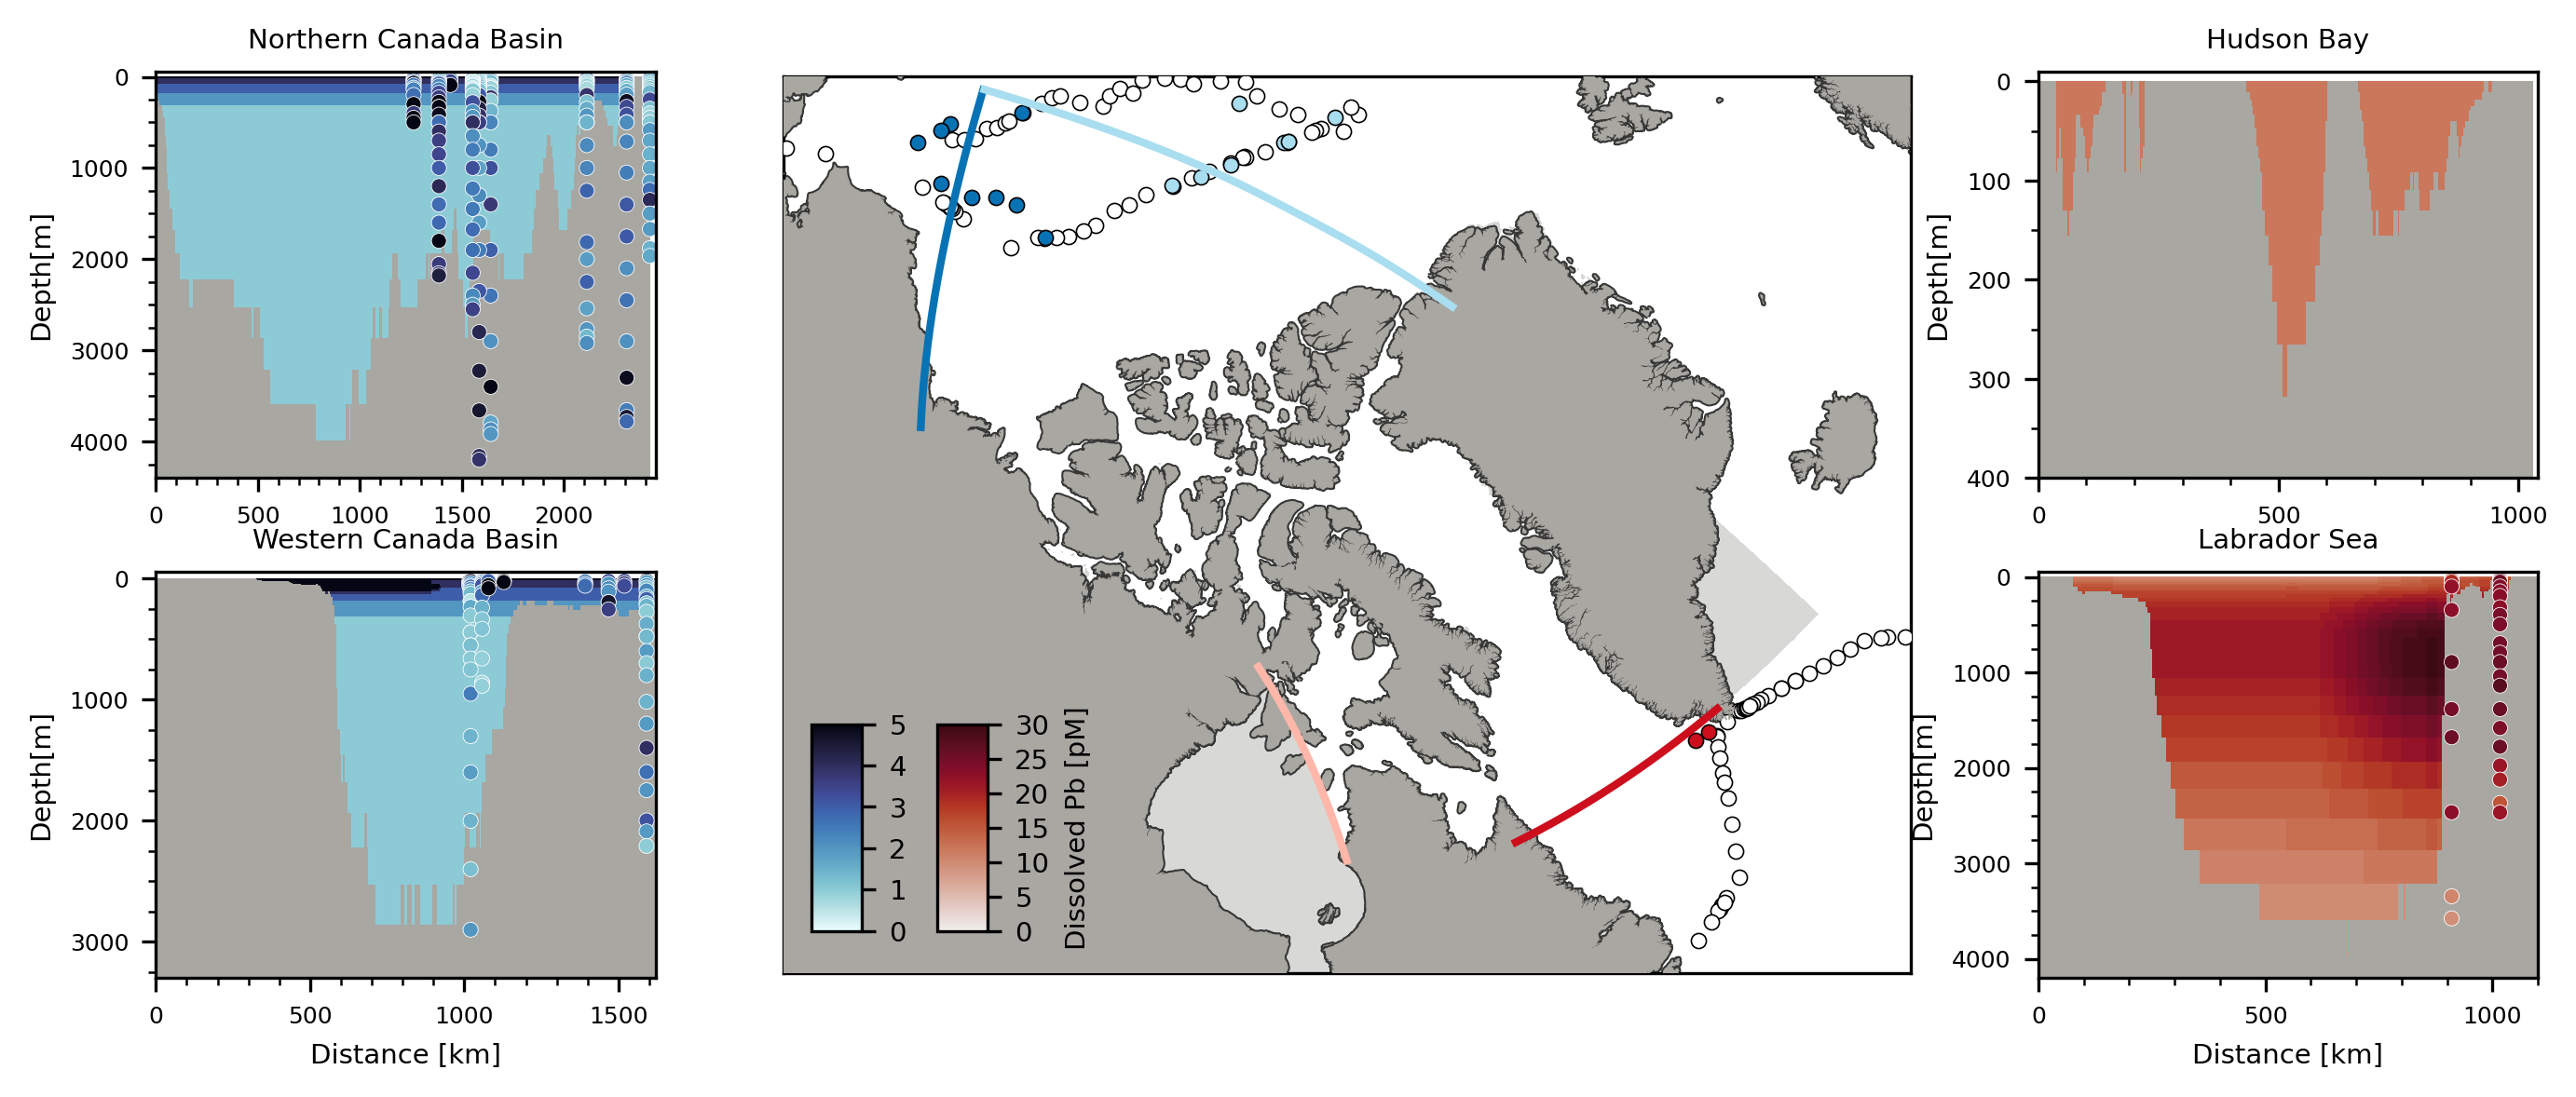

In [22]:
fig = plt.figure(figsize=(4.5*2,3.7), dpi=300)
ax1 = plt.subplot2grid((2, 4), (0, 1), rowspan=2, colspan=2) # map
ax2 = plt.subplot2grid((2, 4), (0, 0)) # left upper
ax3 = plt.subplot2grid((2, 4), (1, 0)) # left bottom
ax4 = plt.subplot2grid((2, 4), (0, 3)) # right upper
ax5 = plt.subplot2grid((2, 4), (1, 3)) # right bottom
axes = [ax2, ax3, ax4, ax5]

for axis in axes:
    axis.yaxis.set_major_locator(MultipleLocator(1000));
    axis.yaxis.set_minor_locator(MultipleLocator(250));  
    axis.xaxis.set_major_locator(MultipleLocator(500));
    axis.xaxis.set_minor_locator(MultipleLocator(100));  
    
ax4.yaxis.set_major_locator(MultipleLocator(100));
ax4.yaxis.set_minor_locator(MultipleLocator(50));  

# ----------- Map ------------------------------------------------
proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj.drawcoastlines(color
                    ='#373736', linewidth=1.0)
proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5)
x, y = proj(mesh_lon, mesh_lat)
proj.contourf(x, y, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

# Domain boundaries: 
proj.plot(x[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], y[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], '-', c=color_sBB, lw=2, zorder=5); 
proj.plot(x[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], y[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], '-', c=color_wCB, lw=2, zorder=5); 
proj.plot(x[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-', c=color_nCB, lw=2, zorder=5);
proj.plot(x[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], y[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], '-', c=color_wHB, lw=2, zorder=5); 

# Label stations shown on the boundary subplots on the central map:
x_all1, y_all1 = proj(AO_lons, AO_lats)
x_all2, y_all2 = proj(NA_lons, NA_lats)
x_AO, y_AO   = proj(AO_obs_lons_compr, AO_obs_lats_compr)
x_CB, y_CB   = proj(CB_obs_lons_compr, CB_obs_lats_compr)
x_BB, y_BB   = proj(BB_obs_lons_compr[2:4], BB_obs_lats_compr[2:4])
proj.scatter(x_all1, y_all1, c='w', s=15, zorder=5, edgecolor='k', linewidth=0.4)
proj.scatter(x_all2, y_all2, c='w', s=15, zorder=5, edgecolor='k', linewidth=0.4)
proj.scatter(x_AO, y_AO, c=color_nCB, s=15, zorder=5, edgecolor='k', linewidth=0.4)
proj.scatter(x_CB, y_CB, c=color_wCB, s=15, zorder=5, edgecolor='k', linewidth=0.4)
proj.scatter(x_BB, y_BB, c=color_sBB, s=15, zorder=5, edgecolor='k', linewidth=0.4)

# -----------  Boundary Condition subplots: ----------- 
# titles:
for ind, ax in enumerate(axes):
    ax.set_title(boundary_names[ind], fontsize=7)
    ax.set_ylabel('Depth[m]', fontsize=7)
        
ax3.set_xlabel('Distance [km]', fontsize=7)
ax5.set_xlabel('Distance [km]', fontsize=7)

vmin_CS1 = 0; vmax_CS1 = 5;
vmin_CS2 = 0; vmax_CS2 = 30;
CS1 = plot_BC(ax2, E_distance, dPb_E[:,-1,::-1], dPb_E_mdepths[:,::-1,-1], \
              AO_obs_distance_compr, AO_obs_depths_compr, AO_dPb_pmolL_compr, \
              xlim=(0,2450), ylim=(4400,-60), vlim=(vmin_CS1,vmax_CS1), cmap=cmocean.cm.ice_r)
CS1 = plot_BC(ax3, N_distance, dPb_N[:,-1,:], dPb_N_mdepths[:,-1,:], \
              CB_obs_distance_compr, CB_obs_depths_compr, CB_dPb_pmolL_compr, \
              xlim=(0,1620), ylim=(3300,-60), vlim=(vmin_CS1,vmax_CS1), cmap=cmocean.cm.ice_r)
CS2 = plot_BC(ax4, W_distance, dPb_W[:,-1,::-1], dPb_W_mdepths[:,::-1,-1], \
              np.empty([]), np.empty([]), np.empty([]), \
              xlim=(0,1040), ylim=(400,-10), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.amp)
CS2 = plot_BC(ax5, S_distance, dPb_S[:,-1,:], dPb_S_mdepths[:,-1,:], \
              BB_obs_distance_compr, BB_obs_depths_compr, BB_dPb_pmolL_compr, \
              xlim=(0,1100), ylim=(4200,-60), vlim=(vmin_CS2,vmax_CS2), cmap=cmocean.cm.amp)

# ---------- Settings: --------------------------------
plt.tight_layout(pad=-0.1, w_pad=0, h_pad=0)

cbaxes1 = fig.add_axes([0.31, 0.13, 0.02, 0.2]) 
cbaxes2 = fig.add_axes([0.36, 0.13, 0.02, 0.2]) 
CBar1 = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, orientation='vertical', ticks=[0,1,2,3,4,5])
CBar2 = plt.colorbar(CS2, ax=ax2, cax=cbaxes2, orientation='vertical', ticks=[0,5,10,15,20,25,30,35,40])
CBar1.ax.tick_params(labelsize=7) 
CBar2.ax.tick_params(labelsize=7) 
CBar2.set_label('Dissolved Pb [pM]', fontsize=7)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/M2-boundary-conditions.png', bbox_inches='tight', dpi=300)

#### Labrador Sea boundary

Show T-S cross section to check the extent of the west greenland current. Chose to compare with 2014 since that is the year of the GA01 cruis of the North Atlantic.

In [23]:
# load year 2015 climatology of ANHA12 gridT file:
df_gridT = nc.Dataset('/data/brogalla/ANHA12/gridT_climatology_2014.nc')
df_gridT

# bdy_temp = np.array(df_gridT.variables['votemper'])[:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
# bdy_sal  = np.array(df_gridT.variables['vosaline'])[:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]

FileNotFoundError: [Errno 2] No such file or directory: b'/data/brogalla/ANHA12/gridT_climatology_2014.nc'

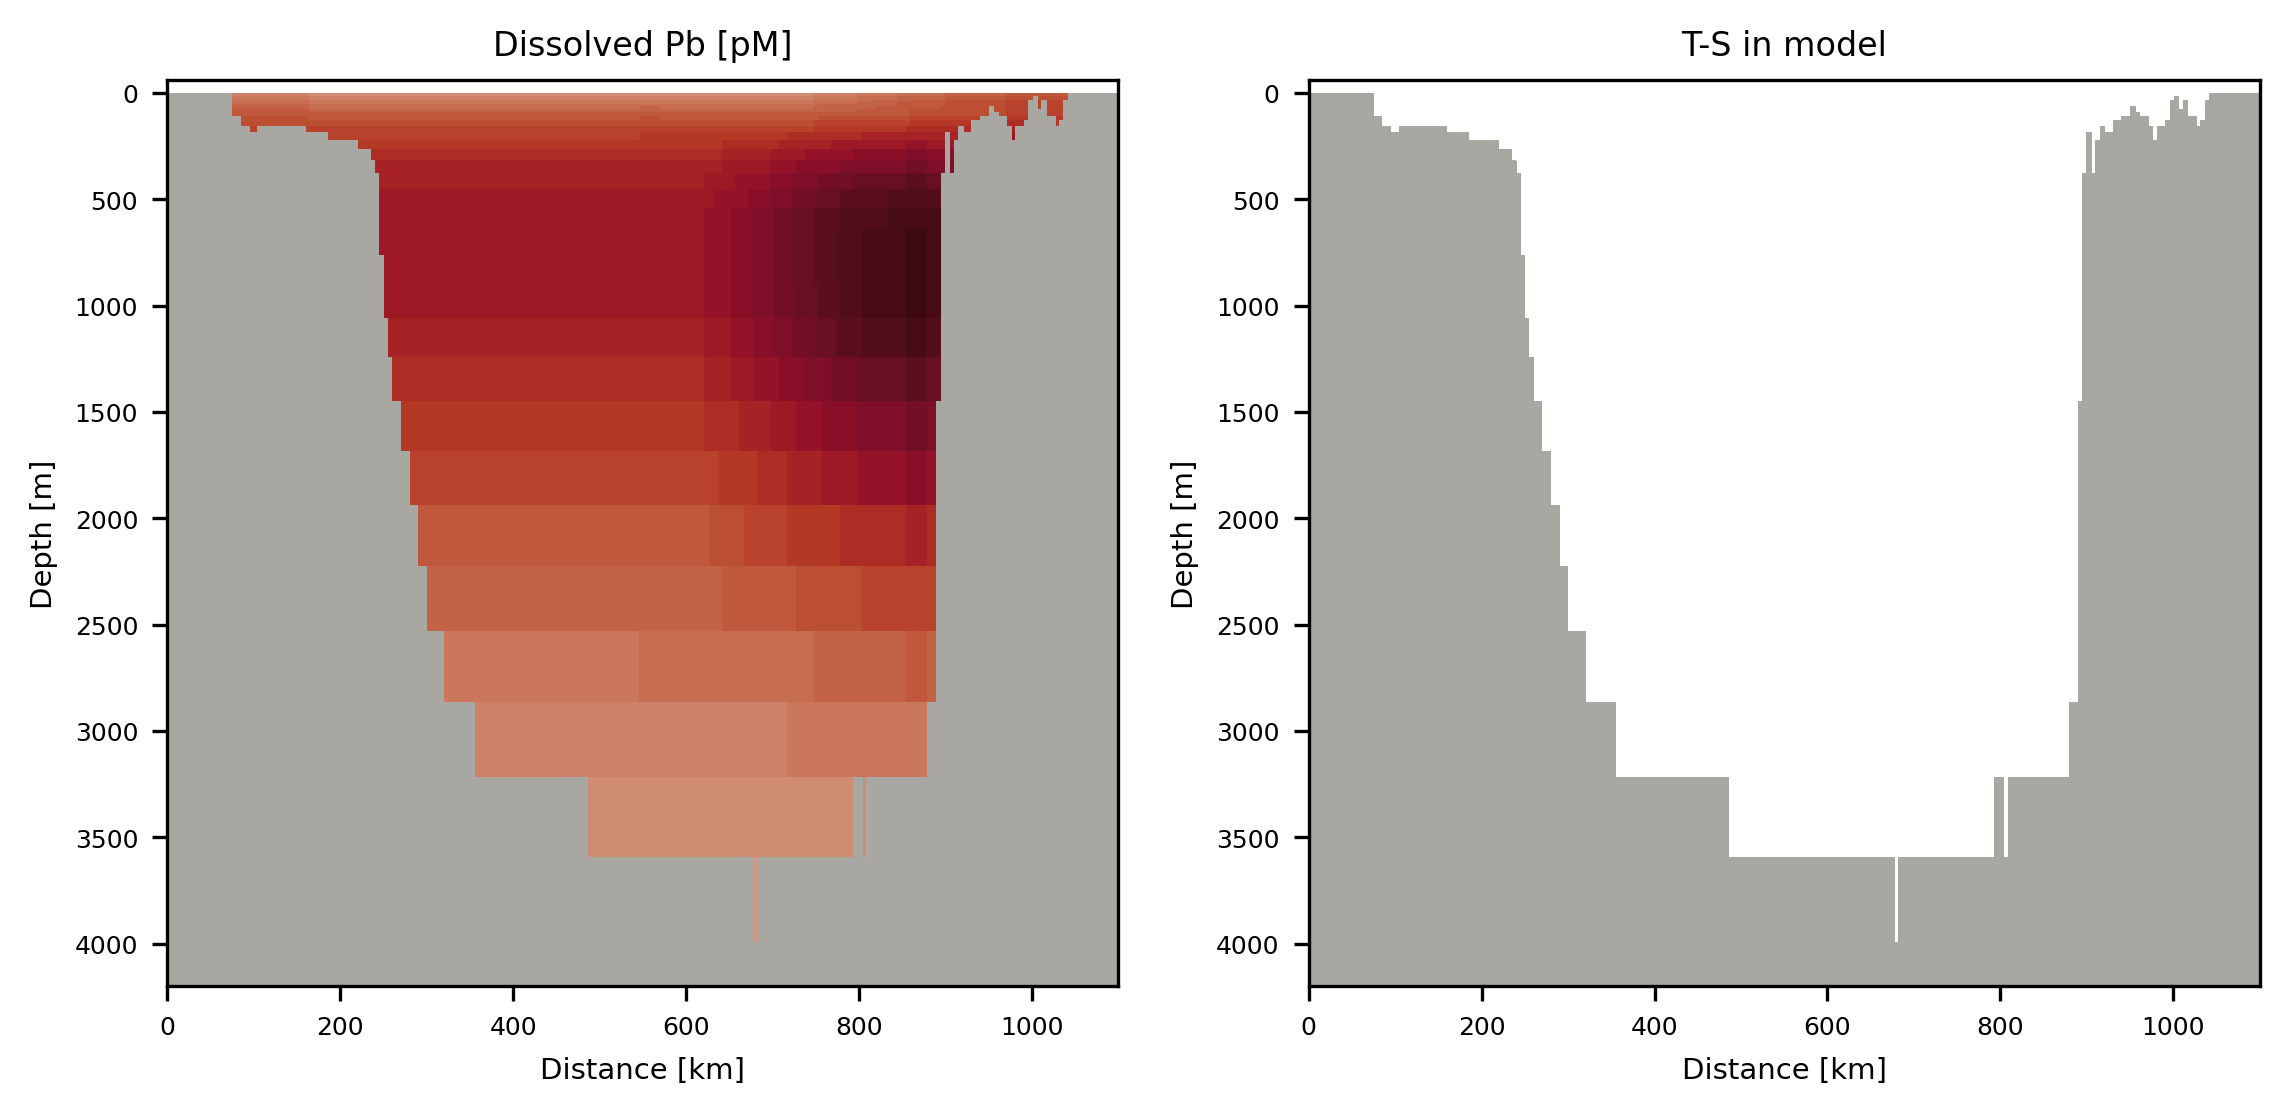

In [81]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(4200, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    
ax[0].set_title('Dissolved Pb [pM]', fontsize=8)
ax[1].set_title('T-S in model', fontsize=8)

# plot model boundary condition:
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, dPb_S[:,-1,:]*1e12, vmin=0, vmax=30, cmap=cmocean.cm.amp)
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
# CB2 = ax[1].pcolormesh(xx, zz, dPb_S[:,-1,:]*1e12, vmin=0, vmax=30, cmap=cmocean.cm.amp)
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))